# Application of Machine Learning using Spectrum Geo-Addressing SDK of Java

In [1]:
# Py4j Library For Executing java 
from py4j.java_gateway import JavaGateway
from py4j.java_gateway import GatewayParameters


import numpy as np
import pandas as pd
import swifter
import json, csv
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import time

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 999)

# Usage of using Addressing APIs using Py4j

In [2]:
gateway = JavaGateway()
addresingGateway = gateway.launch_gateway(classpath = 'Py4JPoC-1.0.jar')
addressing = addresingGateway.jvm.com.precisely.py4j.AddressingGateway()
value = addressing.geocode('221B Baker Street London', 'GBR')
print("Geocoded Co-ordinates: ", value)
value = addressing.verify('221B Baker Street London', 'GBR')
print("Verify Address: ", value)

Geocoded Co-ordinates:  51.52375,-0.15856
Verify Address:  SHERLOCK HOLMES MUSEUM, 221b BAKER STREET, LONDON, NW1 6XE, United Kingdom


# Read Dataset of 100K Addresses for US

In [3]:
us_data = pd.read_csv('US_100K.csv')
us_data.head()

,ID,ADDRESSLINE1,CITY,STATE,ZIP,ADDRESS,COUNTRY
0,21681919,127 MOYER RD,BLAKESLEE,PA,18610.0,"127 MOYER RD,BLAKESLEE,PA,18610",UNITED STATES OF AMERICA
1,21683872,12107 S HALSTED ST,CHICAGO,IL,60628.0,"12107 S HALSTED ST,CHICAGO,IL,60628",UNITED STATES OF AMERICA
2,21684089,801 W WISE ST,BOWIE,TX,76230.0,"801 W WISE ST,BOWIE,TX,76230",UNITED STATES OF AMERICA
3,21684469,1118 BROOKHOLLOW DR,DEER PARK,TX,77536.0,"1118 BROOKHOLLOW DR,DEER PARK,TX,77536",UNITED STATES OF AMERICA
4,21802959,5949 BUFORD HWY 114,NORCROSS,GA,NaN,"5949 BUFORD HWY 114,NORCROSS,GA",UNITED STATES OF AMERICA


# Implement Addressing APIs by calling Java SDK Methods on DataFrames

In [4]:
import concurrent.futures

def geocoding_using_sdk(address, country):
    return addressing.geocode(address, country)

geocode_result = {}
startTime = round(time.time() * 1000)
with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    future_to_address = {executor.submit(geocoding_using_sdk, us_data['ADDRESS'][index], us_data['COUNTRY'][index]): 
                         us_data['ID'][index] for index in us_data.index}
    for future in concurrent.futures.as_completed(future_to_address):
        address_id = future_to_address[future]
        try:
            data = future.result()
        except Exception as exc:
            print('%r generated an exception: %s' % (address_id, exc))
        else:
            geocode_result[address_id] = data
print("Time taken to geocode {0} addresses is {1} ms".format(len(us_data), round(time.time() * 1000) - startTime))
geocode_addresses = pd.Series(geocode_result).to_frame().reset_index()
geocode_addresses.columns = ['ID', 'GEOCODE']
geocode_addresses = geocode_addresses.convert_dtypes(infer_objects=True)
us_data = us_data.merge(geocode_addresses, on='ID')
us_data.head()

Time taken to geocode 99969 addresses is 100827 ms


,ID,ADDRESSLINE1,CITY,STATE,ZIP,ADDRESS,COUNTRY,GEOCODE
0,21681919,127 MOYER RD,BLAKESLEE,PA,18610.0,"127 MOYER RD,BLAKESLEE,PA,18610",UNITED STATES OF AMERICA,"41.021119,-75.490743"
1,21683872,12107 S HALSTED ST,CHICAGO,IL,60628.0,"12107 S HALSTED ST,CHICAGO,IL,60628",UNITED STATES OF AMERICA,"41.673852,-87.641479"
2,21684089,801 W WISE ST,BOWIE,TX,76230.0,"801 W WISE ST,BOWIE,TX,76230",UNITED STATES OF AMERICA,"33.565004,-97.857744"
3,21684469,1118 BROOKHOLLOW DR,DEER PARK,TX,77536.0,"1118 BROOKHOLLOW DR,DEER PARK,TX,77536",UNITED STATES OF AMERICA,"29.683202,-95.132997"
4,21802959,5949 BUFORD HWY 114,NORCROSS,GA,NaN,"5949 BUFORD HWY 114,NORCROSS,GA",UNITED STATES OF AMERICA,"33.936057,-84.216062"


# K-Means Clustering To Visualize The Cluster of Countries using Geo-Coordinates

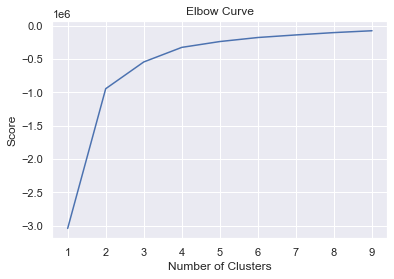

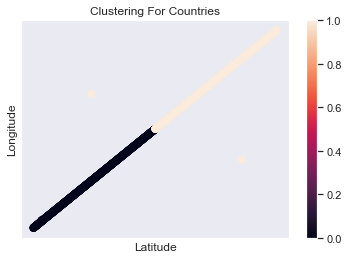

In [5]:
us_data[['LATITUDE', 'LONGITUDE']] = us_data['GEOCODE'].str.split(',', 1, expand=True)
us_data.head()

# K Means Clustering to visualize the clusters of the countries using Geo-coordinates.
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = us_data[['LATITUDE']]
X_axis = us_data[['LONGITUDE']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(us_data[['ID', 'LATITUDE', 'LONGITUDE']]) # Compute k-means clustering.
us_data['cluster_label'] = kmeans.fit_predict(us_data[['ID', 'LATITUDE', 'LONGITUDE']])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(us_data[['ID', 'LATITUDE', 'LONGITUDE']]) # Labels of each point
us_data.head()

sample = pd.DataFrame()
sample = sample.append(us_data[us_data['cluster_label'] == 0][6000:7000], ignore_index=True)
sample = sample.append(us_data[us_data['cluster_label'] == 1][6000:7000], ignore_index=True)
sample = sample.append(us_data[us_data['cluster_label'] == 2][6000:7000], ignore_index=True)

#Plot the clusters obtained using k means
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(sample['LATITUDE'],sample['LONGITUDE'],c=sample['cluster_label'],s=50)
ax.set_title('Clustering For Countries')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_yticks([])
ax.set_xticks([])
plt.colorbar(scatter)

In [6]:
addresingGateway.shutdown()